# Sentiment Classifier using a Parallel Neural Network

> Classification of IMDB Reviews by sentiment

In [10]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten, Dropout, Embedding ,SpatialDropout1D
from tensorflow.keras.layers import concatenate, Input
from tensorflow.keras.layers import CuDNNLSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
tf.__version__

'1.13.1'

## Hyper Parameter choices

In [4]:
out_dir = 'model_out/Parallel/'
epochs = 5
batch_size = 128

n_dim = 64
n_unique = 10000

max_review = 200
pad_type = trunc_type = 'pre'

## Loading the Data

In [5]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique)

In [6]:
x_train = np.asarray(x_train)
y_train = np.asanyarray(y_train)

In [7]:
print(x_train.shape,y_train.shape)

(25000,) (25000,)


## Preprocessing

In [8]:
x_train = pad_sequences(x_train,maxlen=max_review,padding=pad_type,truncating=trunc_type, value=0)

In [9]:
x_valid = pad_sequences(x_valid,maxlen=max_review,padding=pad_type,truncating=trunc_type, value=0)

In [11]:
x_train.shape

(25000, 200)

## Convnet Architecture

In [36]:
def modeler(n_drop=0.2,n_drop_em = 0.2,n_lstm = 20,n_conv = 256):
    inputL = Input(shape=(max_review,),dtype='int16',name='Input')
    
    embedding = Embedding(n_unique,n_dim,input_length=max_review,name="Embedding")(inputL)
    drop_embed = SpatialDropout1D(n_drop_em,name="Embedding_Dropout")(embedding)
    
    conv1 = Conv1D(n_conv,kernel_size=2,activation='relu',name="Conv1")(drop_embed)
    maxp1 = GlobalMaxPool1D(name="MaxPool1")(conv1)
    
    conv2 =  Conv1D(n_conv,kernel_size=3,activation='relu',name="Conv2")(drop_embed)
    maxp2 = GlobalMaxPool1D(name="MaxPool2")(conv2)
    
    conv3 =  Conv1D(n_conv,kernel_size=4,activation='relu',name="Conv3")(drop_embed)
    maxp3 = GlobalMaxPool1D(name="MaxPool3")(conv3)
    
    concater = concatenate([maxp1,maxp2,maxp3])
    
    dense_layer = Dense(100,activation='relu',name="Dense")(concater)
    drop_dense = Dropout(0.4,name="Drop_Dense")(dense_layer)
    prediction = Dense(1,activation='sigmoid')(drop_dense)
    
    model = Model(inputL,prediction)
    model.summary()
    return model

In [37]:
model = modeler()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 200)          0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 200, 64)      640000      Input[0][0]                      
__________________________________________________________________________________________________
Embedding_Dropout (SpatialDropo (None, 200, 64)      0           Embedding[0][0]                  
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 199, 256)     33024       Embedding_Dropout[0][0]          
__________________________________________________________________________________________________
Conv2 (Con

In [38]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelcheckpoint = ModelCheckpoint(filepath=out_dir+"weights.{epoch:02d}.hdf5")
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## Model Training

In [39]:
model.fit(x_train,y_train,batch_size=batch_size,epochs=5,verbose=1,validation_data=(x_valid,y_valid),callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 11s 440us/sample - loss: 0.5228 - acc: 0.7177 - val_loss: 0.3200 - val_acc: 0.8644
Epoch 2/5
25000/25000 [==============================] - 10s 418us/sample - loss: 0.2760 - acc: 0.8900 - val_loss: 0.2804 - val_acc: 0.8816
Epoch 3/5
25000/25000 [==============================] - 11s 439us/sample - loss: 0.1838 - acc: 0.9330 - val_loss: 0.2912 - val_acc: 0.8847
Epoch 4/5
25000/25000 [==============================] - 15s 603us/sample - loss: 0.1124 - acc: 0.9650 - val_loss: 0.3354 - val_acc: 0.8775
Epoch 5/5
25000/25000 [==============================] - 14s 564us/sample - loss: 0.0669 - acc: 0.9802 - val_loss: 0.3758 - val_acc: 0.8745


## Tensorboard Support

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
from time import time

In [ ]:
tensorboard = TensorBoard(log_dir=out_dir+"/tdb/"+"logs/{}".format(time()),histogram_freq=1)

In [ ]:
model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid,y_valid),callbacks=[tensorboard])

In [ ]:
! tensorboard --logdir=model_out/LSTM/tdb/logs/

## Loading Model Weights

In [40]:
model.load_weights(out_dir+'weights.03.hdf5')

In [41]:
x_valid.shape

(25000, 200)

In [43]:
y_hat = model.predict(x_valid,verbose=1)

25000/25000 [==============================] - 2s 95us/sample


In [44]:
y_hat[0]

array([0.00617099], dtype=float32)

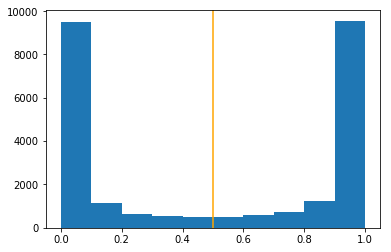

In [45]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5,color = 'orange')

In [46]:
pct = roc_auc_score(y_valid,y_hat)*100.0

In [47]:
"{:0.2f}".format(pct)

'95.32'

In [48]:
def dfr(y_hat):
    y =[]
    for i in y_hat:
        y.append(i[0])
    return y

In [49]:
y_df = dfr(y_hat)

In [50]:
ydf = pd.DataFrame(list(zip(y_df,y_valid)),columns=['y_pred','y_valid'])

In [51]:
ydf.head(10)

,y_pred,y_valid
0,0.006171,0
1,0.991230,1
2,0.980026,1
3,0.643095,0
4,0.997989,1
5,0.815850,1
6,0.967638,1
7,0.001481,0
8,0.994386,0
9,0.986527,1
